In [35]:
%load_ext autoreload
%autoreload 2

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import networkx as nx

import glob
import re
import os
# os.environ["CUDA_VISIBLE_DEVICES"] = "-1"
# import sys
# sys.path.append('/root/digital-twin/wireless_digital_twin/')

import tensorflow as tf
print(tf.test.gpu_device_name())


import utils.utilfunc as uf
from utils.models import PlanNet, RouteNet
from utils.datagen_old import PlanDataGen, get_output_format
import utils.datagen as dg

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
/device:GPU:0


2022-12-27 03:53:41.441240: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1613] Created device /device:GPU:0 with 9308 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 2080 Ti, pci bus id: 0000:17:00.0, compute capability: 7.5
2022-12-27 03:53:41.441639: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1613] Created device /device:GPU:1 with 9305 MB memory:  -> device: 1, name: NVIDIA GeForce RTX 2080 Ti, pci bus id: 0000:65:00.0, compute capability: 7.5


# Topological feature and data

More notes: https://docs.google.com/document/d/1Quh3fxewslm5BNcHFHodOhYpK0U519sxl_gL0zneZ-o/edit?usp=sharing

More topologies & datasets: https://knowledgedefinednetworking.org

In [36]:
# abidata = '/root/digital-twin/digi_twin_summer_wireless_dataset-e3cce9c3860f1c1f3de8a0dcb5c744bb16ee4f34/data_split_clean'
# abidata2 = '/root/digital-twin/digi_twin_summer_wireless_dataset-e3cce9c3860f1c1f3de8a0dcb5c744bb16ee4f34/dataset-2'

config  = uf.PathConfigParser('./configs/c2.ini').as_dict()
hparams = dict(**config['GNN'], **config['LearningParams'])

datagens, datasets = dg.get_data_gens_sets(config)
config



<class 'networkx.utils.decorators.argmap'> compilation 9:4: FutureWarning: laplacian_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
/root/digital-twin/wireless_digital_twin/utils/datagen.py:238: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  adjacency = nx.adjacency_matrix(self.graph_topology_undirected)


ValueError: TypeError: sparse matrix length is ambiguous; use getnnz() or shape[0]
Traceback (most recent call last):

  File "/usr/local/lib/python3.8/dist-packages/scipy/sparse/_base.py", line 345, in __len__
    raise TypeError("sparse matrix length is ambiguous; use getnnz()"

TypeError: sparse matrix length is ambiguous; use getnnz() or shape[0]



In [37]:
from utils.datagen import getTopology, getDirectedTopology

gfile = './dataset/nsfnet.txt'
# gfile = '../GNNetworkingChallenge/data/full_data/gnnet_data_set_validation/graphs/graph-gbn-wfq-0.txt'
multiGraph = nx.read_gml(gfile, destringizer=int)
nx.info(multiGraph)

# getTopology
g_und=nx.Graph()
for uu, vv, keys, weight in multiGraph.edges(data="bandwidth", keys=True):
    g_und.add_edge(uu, vv)
    #print(uu, vv, keys, weight)

# getDirectedTopology
g_dir=nx.DiGraph()
for uu, vv, keys, weight in multiGraph.edges(data="bandwidth", keys=True):
    g_dir.add_edge(uu, vv)

/tmp/ipykernel_74661/2901686274.py:6: DeprecationWarning: info is deprecated and will be removed in version 3.0.

  nx.info(multiGraph)


dict_keys(['n_paths', 'n_links', 'n_nodes', 'n_total', 'paths_to_links', 'links_to_paths', 'sequences_paths_links', 'links_to_nodes', 'nodes_to_links', 'sequences_links_nodes', 'paths_to_nodes', 'nodes_to_paths', 'sequences_nodes_paths', 'laplacian_matrix', 'adjacency_matrix', 'node_init', 'path_init', 'link_init'])


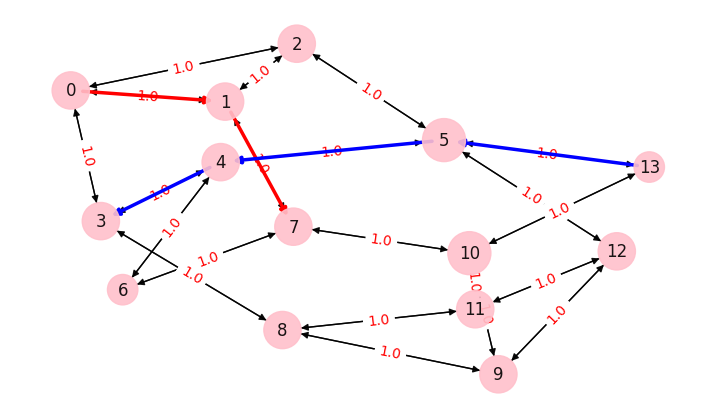

In [4]:
G = g_dir
pos = nx.nx_agraph.graphviz_layout(G, prog='fdp', root=0)
# pos = nx.spring_layout(G)
deg = nx.degree(G)

# draw paths
paths = datagens['train'].paths[[0, -1]]
edges = []
for r in paths:
    route_edges = [(r[n],r[n+1]) for n in range(len(r)-1)]
    edges.append(route_edges)
colors = [[1,0,0,1], [0,0,1,1], [0,1,0,1], [0,1,1,1]]
linews = [2.5]*len(paths)

plt.figure(figsize=(7,4))

x_ex = datagens['train'].__getitem__(0)[0]
print(x_ex.keys())
nx.draw(
    G, pos, edge_color='black', width=1, linewidths=1,
    node_size=[(deg[node]/2)*240 for node in G.nodes()], node_color='pink', alpha=0.9,
    labels={node: node for node in G.nodes()}
)
nx.draw_networkx_edge_labels(
    G, pos,
    edge_labels=dict(zip(G.edges(), x_ex['link_init'].numpy())),
    font_color='red'
)
for ctr, edgelist in enumerate(edges):
    nx.draw_networkx_edges(
        G, pos=pos,
        edgelist=edgelist,
        edge_color=colors[ctr], 
        width=linews[ctr]
    )

plt.axis('off')
plt.show()


In [5]:
# # Gets all links and nodes as lists in the correct format. 
# links, nodes = self.get_links_nodes_arrays()
nodes = sorted(list(G.nodes()))
links = [list(elem) for elem in list(np.array(G.edges()))]
paths = datagens['train'].paths


# # Get Path-Link related features. 
# paths_to_links, links_to_paths, sequences_paths_links = self.get_path_link_features(links)
sequences_paths_links = []
paths_to_links = []
links_to_paths = []
for pi, elem in enumerate(paths): # for each path
    num_nodes = len(list(elem))
    for ni in range(len(elem)-1): # for each node in the path until the last but one
        paths_to_links.append(pi)        # append path index
        sequences_paths_links.append(ni) # append the index of node in the path 
        b = [elem[ni], elem[ni+1]]       # the link from src node to dst node
        a = links.index(b)
        links_to_paths.append(a)
print('paths_to_links:', len(paths_to_links), paths_to_links)
print('links_to_paths:', len(links_to_paths), links_to_paths)
print('sequences_paths_links:', len(sequences_paths_links), sequences_paths_links) #18


# # Get Node-Link related features 
# nodes_to_links, sequences_links_nodes, links_to_nodes = self.get_links_nodes(links, nodes)
nodes_to_links = []
sequences_links_nodes = []
for count_link, elem in enumerate(nodes): # for each node
    for i in range(len(links)): # for each link
        if links[i][0] == elem:           # if this node is the source node of the link 
            nodes_to_links.append(i)                 # append link index
            sequences_links_nodes.append(count_link) # append node count (same to node index)
links_to_nodes = []
for i in range(len(links)): # for each link
    links_to_nodes.append(links[i][0]) # append the source node index
print('nodes_to_links:', len(nodes_to_links), nodes_to_links)
print('sequences_links_nodes:', len(sequences_links_nodes), sequences_links_nodes)
print('links_to_nodes:', len(links_to_nodes), links_to_nodes) #42


# # Path-Node
# nodes_to_paths, paths_to_nodes, sequences_nodes_paths = self.get_paths_nodes()
nodes_to_paths = [] 
paths_to_nodes = []
sequences_nodes_paths = []
for count_path, elem in enumerate(paths):  # for each path
    count0 = -1
    for i in range(len(elem)):  # for each node in the path
        count0 += 1 #0
        if i < (len(elem)-1):           # if not the last node
            nodes_to_paths.append(elem[i])       # append node index
            paths_to_nodes.append(count_path)    # append path index 
            sequences_nodes_paths.append(count0) # append the index of node in the path 
print('nodes_to_paths:', len(nodes_to_paths), nodes_to_paths)
print('paths_to_nodes:', len(paths_to_nodes), paths_to_nodes)
print('sequences_nodes_paths:', len(sequences_nodes_paths), sequences_nodes_paths) #18

# # Degrees and Lalpacian Matrix.
# degrees = [degree for _,degree in G.out_degree()]
degrees = [degree for _,degree in G.out_degree()]
print('degrees:', degrees)

# # Get sparse Laplacian Matrix.
# laplacian = nx.laplacian_matrix(self.graph_topology_undirected) 
# adjacency = nx.adjacency_matrix(self.graph_topology_undirected) 

# # Convert it to dense format.
# laplacian = laplacian.todense()
# adjacency = adjacency.todense()


paths_to_links: 18 [0, 0, 1, 1, 1, 2, 2, 3, 4, 4, 5, 6, 6, 7, 8, 9, 9, 9]
links_to_paths: 18 [0, 5, 5, 14, 34, 11, 18, 6, 25, 20, 38, 33, 36, 40, 28, 30, 16, 19]
sequences_paths_links: 18 [0, 1, 0, 1, 2, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 2]
nodes_to_links: 42 [0, 1, 2, 3, 4, 5, 9, 10, 11, 6, 7, 8, 19, 20, 21, 15, 16, 17, 18, 25, 26, 12, 13, 14, 22, 23, 24, 36, 37, 38, 32, 33, 34, 35, 39, 40, 41, 27, 28, 29, 30, 31]
sequences_links_nodes: 42 [0, 0, 0, 1, 1, 1, 2, 2, 2, 3, 3, 3, 4, 4, 4, 5, 5, 5, 5, 6, 6, 7, 7, 7, 8, 8, 8, 9, 9, 9, 10, 10, 10, 10, 11, 11, 11, 12, 12, 12, 13, 13]
links_to_nodes: 42 [0, 0, 0, 1, 1, 1, 3, 3, 3, 2, 2, 2, 7, 7, 7, 5, 5, 5, 5, 4, 4, 4, 8, 8, 8, 6, 6, 12, 12, 12, 13, 13, 10, 10, 10, 10, 9, 9, 9, 11, 11, 11]
nodes_to_paths: 18 [0, 1, 1, 7, 10, 2, 5, 3, 6, 4, 9, 10, 9, 11, 12, 13, 5, 4]
paths_to_nodes: 18 [0, 0, 1, 1, 1, 2, 2, 3, 4, 4, 5, 6, 6, 7, 8, 9, 9, 9]
sequences_nodes_paths: 18 [0, 1, 0, 1, 2, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 2]
degrees: [3, 3, 3, 3, 

In [6]:
print([p for p in paths])

[[0, 1, 7], [1, 7, 10, 11], [2, 5, 13], [3, 0], [6, 4, 5], [9, 12], [10, 9, 8], [11, 10], [12, 9], [13, 5, 4, 3]]


# Model forward pass

In [25]:
datagens['train'].__getitem__(0)[0]

{'n_paths': <tf.Variable 'n_paths:0' shape=() dtype=int32, numpy=10>,
 'n_links': <tf.Variable 'n_links:0' shape=() dtype=int32, numpy=42>,
 'n_nodes': <tf.Variable 'n_nodes:0' shape=() dtype=int32, numpy=14>,
 'n_total': <tf.Variable 'n_total:0' shape=() dtype=int32, numpy=18>,
 'paths_to_links': <tf.Variable 'paths_to_links:0' shape=(18,) dtype=int32, numpy=array([0, 0, 1, 1, 1, 2, 2, 3, 4, 4, 5, 6, 6, 7, 8, 9, 9, 9], dtype=int32)>,
 'links_to_paths': <tf.Variable 'links_to_paths:0' shape=(18,) dtype=int32, numpy=
 array([ 0,  5,  5, 14, 34, 11, 18,  6, 25, 20, 38, 33, 36, 40, 28, 30, 16,
        19], dtype=int32)>,
 'sequences_paths_links': <tf.Variable 'sequences_paths_links:0' shape=(18,) dtype=int32, numpy=array([0, 1, 0, 1, 2, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 2], dtype=int32)>,
 'links_to_nodes': <tf.Variable 'links_to_nodes:0' shape=(42,) dtype=int32, numpy=
 array([ 0,  0,  0,  1,  1,  1,  3,  3,  3,  2,  2,  2,  7,  7,  7,  5,  5,
         5,  5,  4,  4,  4,  8,  8,  8,  6

In [64]:
from utils.models import PlanNet, RouteNet

model = PlanNet(hparams, train_on = 'delay')
# model = RouteNet(hparams, train_on = 'delay')

model.build()
opt = tf.keras.optimizers.Adam(learning_rate=hparams['learning_rate'])
model.compile(optimizer=opt, run_eagerly=False)

model(datagens['train'].__getitem__(0)[0])


(42, 32)
(42, 32)
(42, 32)
(42, 32)


<tf.Tensor: shape=(10, 1), dtype=float32, numpy=
array([[0.82685673],
       [0.68257487],
       [0.87695014],
       [1.0970073 ],
       [0.7538131 ],
       [0.8743453 ],
       [0.598865  ],
       [0.987635  ],
       [1.3261666 ],
       [0.71810055]], dtype=float32)>

In [60]:
ds = datasets['train'].batch(10)
iterator = tf.data.make_initializable_iterator(ds)
batch_data = iterator.get_next()
with tf.Session() as sess:
    sess.run(iterator.initializer)
    print(np.shape(sess.run(batch_data)[0])[0])
    
    

# for element in datasets['train'].batch(10).get_single_element(): 
#     print(model(element[0]))
#     break

AttributeError: module 'tensorflow._api.v2.data' has no attribute 'make_initializable_iterator'

In [65]:
datagens['train'].batch(10)

AttributeError: 'PlanDataGensMulti' object has no attribute 'batch'